In [1]:
#!pip install opencv-python

import tensorflow as tf 
print(tf.__version__)

import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

import warnings
warnings.filterwarnings("ignore")

slim = tf.contrib.slim

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import vizualization

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

1.12.0


In [2]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

In [3]:
# Input placeholder.
net_shape = (300, 300)
data_format ='NCHW' # 'NHWC' # 'NCHW'

img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
#img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))

# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

In [ ]:
ssd_net.params

In [4]:
# Restore SSD model.
#ckpt_root = '/scratch365/pmoreira/lunotim_ssd/experiment1/checkpoints/'
#ckpt_filename = ckpt_root + 'model.ckpt-192206' #192844'

#ckpt_root = '/scratch365/pmoreira/lunotim_ssd/experiment1/checkpoints_192844/'
#ckpt_filename = ckpt_root + 'model.ckpt-192844'

# More recently checkpoint
ckpt_root = '/scratch365/pmoreira/lunotim_ssd/experiment1/checkpoints/'
ckpt_filename = ckpt_root + 'model.ckpt-448651'

isess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from /scratch365/pmoreira/lunotim_ssd/experiment1/checkpoints/model.ckpt-448651


In [5]:
# Post-processing pipeline

# Main image processing routine.
def process_image(img, select_threshold=0.502, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    #print('rpredictions', rlocalisations)
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=2, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    

    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes



from xml.dom import minidom
import xml.etree.ElementTree as ET


def get_bbox_from_xml(fn):
    tree = ET.parse(fn)
    root = tree.getroot() 

    bboxes = {
    'xmin': [int(xmin.text) for xmin in root.iter('xmin')],
    'xmax': [int(xmax.text) for xmax in root.iter('xmax')],
    'ymin': [int(ymin.text) for ymin in root.iter('ymin')],
    'ymax': [int(ymax.text) for ymax in root.iter('ymax')]    
    }

    return bboxes 

In [7]:
import os
import cv2

image_root_path = '/scratch365/pmoreira/datasets/lunotim/experiment1/test/Images/'
annot_root_path = '/scratch365/pmoreira/datasets/lunotim/experiment1/test/Annotations/'


# Test on some demo image and visualize output.
image_names = ['tp-ITDS-add-LIDC-IDRI-0021-000132.png',
               'tp-ITDS-add-LIDC-IDRI-0039-000195.png',
               'tp-ITDS-add-LIDC-IDRI-0079-000059.png',               
               'tp-OTDS-add-LIDC-IDRI-0517-000043.png',
               'tp-OTDS-add-LIDC-IDRI-0520-000182.png',
               'tp-ctGAN-rem-LIDC-IDRI-0066-000591.png',
               'tp-ctGAN-rem-LIDC-IDRI-0064-000081.png',
               'tp-ctGAN-rem-LIDC-IDRI-0061-000080.png', # retirar do dataset
               'tp-OTDS-add-LIDC-IDRI-0626-000088.png',
               'tp-ITDS-add-LIDC-IDRI-0110-000058.png',
               'tp-OTDS-add-LIDC-IDRI-0599-000197.png',
               'tp-ITSS-add-LIDC-IDRI-0186-000112.png',
               'tp-OTSS-add-LIDC-IDRI-0680-000048.png',
               'tp-OTSS-add-LIDC-IDRI-0711-000114.png',
               'tp-SI-rem-LIDC-IDRI-0549-000072.png',
               'tp-SI-rem-LIDC-IDRI-0545-000436.png',
               'tp-ctGAN-rem-LIDC-IDRI-0066-000610.png',
               'tp-PGI-rem-LIDC-IDRI-0973-000099.png',
               'tp-ctGAN-add-LIDC-IDRI-0001-000031.png',
               'tp-ctGAN-add-LIDC-IDRI-0209-000051.png'
              ]

tp-SI-rem-LIDC-IDRI-0549-000072.png
[0.9938692  0.10155895 0.09269263 0.09146073 0.0914042  0.09086453
 0.089851   0.08968951 0.0896019  0.08896218 0.08872861 0.08839574
 0.08828603 0.08812176 0.08799289 0.08794212 0.08776829 0.08776721
 0.0877034  0.08754376 0.08735183 0.08730464 0.08727927 0.08722489
 0.08712834 0.08707736 0.08680315 0.08676005 0.08645353 0.08624475]


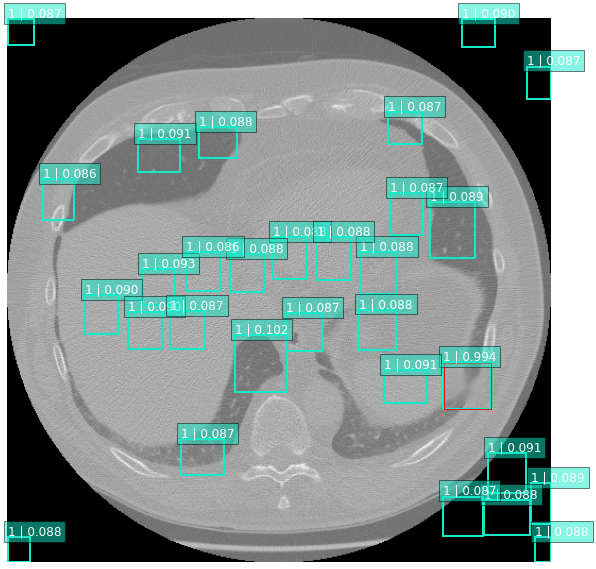

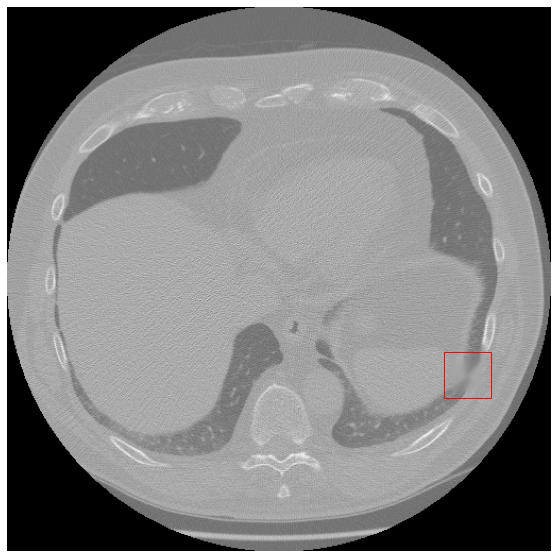

In [30]:
img_fn = image_names[14]
xml_fn = annot_root_path + img_fn.replace('.png', '.xml')

img = cv2.imread(image_root_path + img_fn)

rclasses, rscores, rbboxes =  process_image(img, select_threshold=0.502, nms_threshold=0.45) 
rclasses, rscores, rbboxes =  process_image(img, select_threshold=0.086, nms_threshold=.01) # 0.502 .45)
bboxes_gt = get_bbox_from_xml(xml_fn)

print(img_fn)
#print(rclasses, rscores, rbboxes)
print(rscores)

vizualization.plt_bboxes(img, rclasses, rscores, rbboxes, bboxes_gt)
vizualization.plt_bboxes_gt(img, bboxes_gt)

In [9]:
!ls /scratch365/pmoreira/datasets/lunotim/experiment1/test/Images/

tp-ITDS-add-LIDC-IDRI-0001-000079.png  tp-OTDS-add-LIDC-IDRI-0514-000068.png
tp-ITDS-add-LIDC-IDRI-0001-000085.png  tp-OTDS-add-LIDC-IDRI-0515-000152.png
tp-ITDS-add-LIDC-IDRI-0001-000093.png  tp-OTDS-add-LIDC-IDRI-0515-000156.png
tp-ITDS-add-LIDC-IDRI-0001-000095.png  tp-OTDS-add-LIDC-IDRI-0516-000117.png
tp-ITDS-add-LIDC-IDRI-0001-000120.png  tp-OTDS-add-LIDC-IDRI-0517-000043.png
tp-ITDS-add-LIDC-IDRI-0001-000121.png  tp-OTDS-add-LIDC-IDRI-0517-000047.png
tp-ITDS-add-LIDC-IDRI-0001-000122.png  tp-OTDS-add-LIDC-IDRI-0517-000048.png
tp-ITDS-add-LIDC-IDRI-0002-000080.png  tp-OTDS-add-LIDC-IDRI-0517-000059.png
tp-ITDS-add-LIDC-IDRI-0002-000116.png  tp-OTDS-add-LIDC-IDRI-0517-000104.png
tp-ITDS-add-LIDC-IDRI-0002-000118.png  tp-OTDS-add-LIDC-IDRI-0517-000105.png
tp-ITDS-add-LIDC-IDRI-0002-000144.png  tp-OTDS-add-LIDC-IDRI-0517-000107.png
tp-ITDS-add-LIDC-IDRI-0002-000152.png  tp-OTDS-add-LIDC-IDRI-0517-000108.png
tp-ITDS-add-LIDC-IDRI-0002-000155.png  tp-OTDS-add-LIDC-IDRI-0518-000047.png

tp-ITDS-add-LIDC-IDRI-0643-000101.png  tp-OTSS-add-LIDC-IDRI-0139-000089.png
tp-ITDS-add-LIDC-IDRI-0643-000106.png  tp-OTSS-add-LIDC-IDRI-0140-000167.png
tp-ITDS-add-LIDC-IDRI-0644-000118.png  tp-OTSS-add-LIDC-IDRI-0140-000168.png
tp-ITDS-add-LIDC-IDRI-0645-000087.png  tp-OTSS-add-LIDC-IDRI-0140-000170.png
tp-ITDS-add-LIDC-IDRI-0645-000152.png  tp-OTSS-add-LIDC-IDRI-0141-000138.png
tp-ITDS-add-LIDC-IDRI-0645-000163.png  tp-OTSS-add-LIDC-IDRI-0141-000143.png
tp-ITDS-add-LIDC-IDRI-0646-000064.png  tp-OTSS-add-LIDC-IDRI-0141-000151.png
tp-ITDS-add-LIDC-IDRI-0646-000072.png  tp-OTSS-add-LIDC-IDRI-0141-000155.png
tp-ITDS-add-LIDC-IDRI-0646-000083.png  tp-OTSS-add-LIDC-IDRI-0141-000203.png
tp-ITDS-add-LIDC-IDRI-0646-000138.png  tp-OTSS-add-LIDC-IDRI-0141-000207.png
tp-ITDS-add-LIDC-IDRI-0646-000139.png  tp-OTSS-add-LIDC-IDRI-0141-000223.png
tp-ITDS-add-LIDC-IDRI-0646-000140.png  tp-OTSS-add-LIDC-IDRI-0141-000226.png
tp-ITDS-add-LIDC-IDRI-0646-000145.png  tp-OTSS-add-LIDC-IDRI-0141-000232.png

tp-ITSS-add-LIDC-IDRI-0463-000119.png  tp-OTSS-add-LIDC-IDRI-0954-000176.png
tp-ITSS-add-LIDC-IDRI-0463-000235.png  tp-OTSS-add-LIDC-IDRI-0954-000181.png
tp-ITSS-add-LIDC-IDRI-0464-000108.png  tp-OTSS-add-LIDC-IDRI-0954-000185.png
tp-ITSS-add-LIDC-IDRI-0464-000110.png  tp-OTSS-add-LIDC-IDRI-0954-000212.png
tp-ITSS-add-LIDC-IDRI-0464-000125.png  tp-OTSS-add-LIDC-IDRI-0955-000145.png
tp-ITSS-add-LIDC-IDRI-0464-000156.png  tp-OTSS-add-LIDC-IDRI-0955-000152.png
tp-ITSS-add-LIDC-IDRI-0464-000163.png  tp-OTSS-add-LIDC-IDRI-0955-000153.png
tp-ITSS-add-LIDC-IDRI-0464-000166.png  tp-OTSS-add-LIDC-IDRI-0955-000168.png
tp-ITSS-add-LIDC-IDRI-0465-000083.png  tp-OTSS-add-LIDC-IDRI-0955-000169.png
tp-ITSS-add-LIDC-IDRI-0465-000086.png  tp-OTSS-add-LIDC-IDRI-0955-000200.png
tp-ITSS-add-LIDC-IDRI-0465-000100.png  tp-OTSS-add-LIDC-IDRI-0955-000223.png
tp-ITSS-add-LIDC-IDRI-0465-000102.png  tp-OTSS-add-LIDC-IDRI-0955-000225.png
tp-ITSS-add-LIDC-IDRI-0465-000110.png  tp-OTSS-add-LIDC-IDRI-0955-000227.png

tp-OTDS-add-LIDC-IDRI-0263-000075.png  tp-SI-rem-LIDC-IDRI-0671-000112.png
tp-OTDS-add-LIDC-IDRI-0263-000097.png  tp-SI-rem-LIDC-IDRI-0671-000197.png
tp-OTDS-add-LIDC-IDRI-0264-000028.png  tp-SI-rem-LIDC-IDRI-0671-000204.png
tp-OTDS-add-LIDC-IDRI-0264-000030.png  tp-SI-rem-LIDC-IDRI-0672-000176.png
tp-OTDS-add-LIDC-IDRI-0264-000036.png  tp-SI-rem-LIDC-IDRI-0673-000409.png
tp-OTDS-add-LIDC-IDRI-0264-000040.png  tp-SI-rem-LIDC-IDRI-0673-000478.png
tp-OTDS-add-LIDC-IDRI-0265-000068.png  tp-SI-rem-LIDC-IDRI-0674-000122.png
tp-OTDS-add-LIDC-IDRI-0265-000069.png  tp-SI-rem-LIDC-IDRI-0674-000165.png
tp-OTDS-add-LIDC-IDRI-0265-000098.png  tp-SI-rem-LIDC-IDRI-0674-000184.png
tp-OTDS-add-LIDC-IDRI-0265-000100.png  tp-SI-rem-LIDC-IDRI-0674-000277.png
tp-OTDS-add-LIDC-IDRI-0266-000164.png  tp-SI-rem-LIDC-IDRI-0676-000168.png
tp-OTDS-add-LIDC-IDRI-0266-000171.png  tp-SI-rem-LIDC-IDRI-0678-000106.png
tp-OTDS-add-LIDC-IDRI-0266-000199.png  tp-SI-rem-LIDC-IDRI-0678-000108.png
tp-OTDS-add-LIDC-IDRI-026